Library

In [1]:
import yfinance as yf
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

Import Data

In [220]:
df = yf.download("META", start = "2020-01-01", end = "2025-05-01")
print(date.today().strftime("%Y-%m-%d"))

data = df['Close'].values

print("Record:",len(data))
print(df.tail())

[*********************100%***********************]  1 of 1 completed

2025-05-02
Record: 1339
Price            Close        High         Low        Open    Volume
Ticker            META        META        META        META      META
Date                                                                
2025-04-24  533.150024  533.900024  517.500000  518.729980  13910000
2025-04-25  547.270020  549.859985  536.250000  546.799988  17098900
2025-04-28  549.739990  558.489990  540.590027  555.640015  15179000
2025-04-29  554.440002  556.570007  544.119995  546.000000  11835000
2025-04-30  549.000000  549.099976  529.500000  538.400024  29244000


Plot Graph

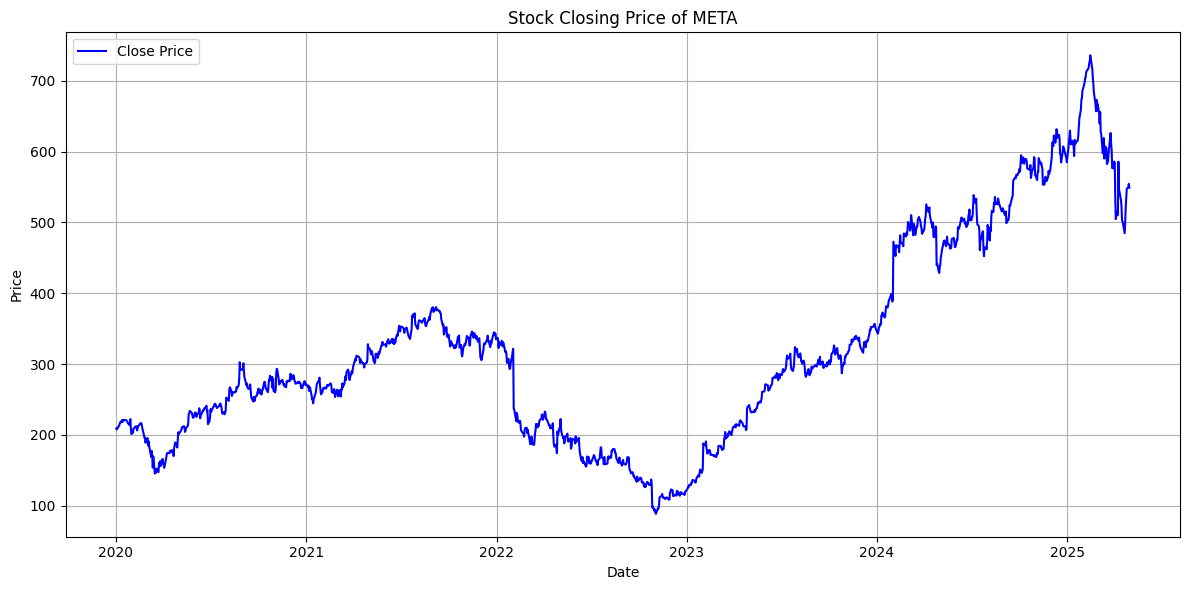

In [221]:
plt.figure(figsize = (12, 6))
plt.plot(df.index, data, label = 'Close Price', color = 'blue')
plt.title("Stock Closing Price of META")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Scale Data Into [0,1] and 2D

In [222]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

Split Data and Select Time Step

In [223]:
time_step = 60
train_size = int(len(scaled_data) * 0.8) 
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

X_train, y_train = [], []
X_test, y_test = [], []

for i in range(time_step, len(train_data)):
    X_train.append(train_data[i-time_step:i, 0])
    y_train.append(train_data[i, 0])

for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i, 0])
    y_test.append(test_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(len(X_train), len(y_train), len(X_test), len(y_test))

1011 1011 208 208


Model LSTM

In [252]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = 'mean_squared_error')

c:\Users\BOSS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Model

In [253]:
history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_split = 0.2)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0260 - val_loss: 0.0065
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0014 - val_loss: 7.3073e-04
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 9.8704e-04 - val_loss: 0.0011
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0011 - val_loss: 8.4996e-04
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.1490e-04 - val_loss: 6.0492e-04
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 9.9802e-04 - val_loss: 6.8137e-04
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 9.0135e-04 - val_loss: 6.7922e-04
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 9.1122e-04 - val_loss: 5.6716e-04
Epoch 12/50
26/26 ━

Check Overfitting

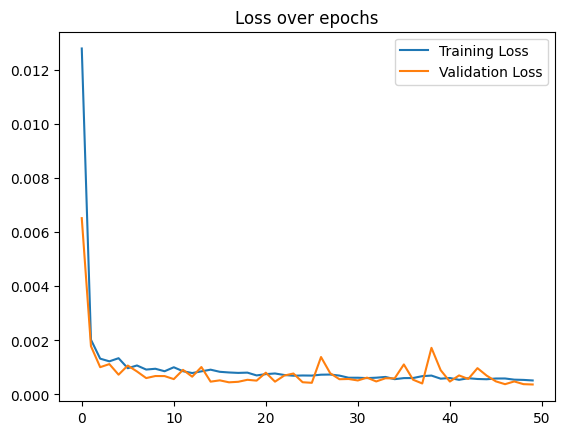

In [254]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [255]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = scaler.inverse_transform(train_pred)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
test_pred_inv = scaler.inverse_transform(test_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

rmse_train = np.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
rmse_test = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Train RMSE: 12.659696678285325
Test RMSE: 21.01148540830744


Evalute Model

In [256]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [257]:
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)


Mean Squared Error (MSE): 441.4825190635164
Root Mean Squared Error (RMSE): 21.01148540830744
R² Score: 0.884380495276179


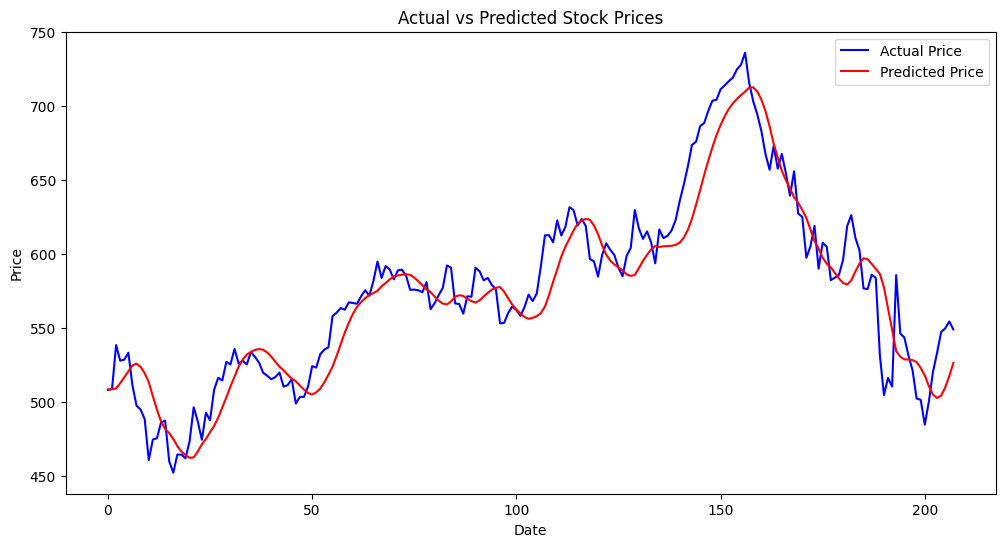

In [258]:
plt.figure(figsize = (12, 6))
plt.plot(y_test_actual, label = "Actual Price", color = 'blue')
plt.plot(predictions, label = "Predicted Price", color = 'red')
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

Save Model

In [259]:
model.save("META_model1.h5")

In [260]:
model = load_model("META_model1.h5")

Prediction

In [264]:
df = yf.download("META", start = "2020-01-01", end = "2025-05-01")
data = df['Close'].values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

[*********************100%***********************]  1 of 1 completed


In [266]:
time_step = 60
dataf = yf.download("META", period = "61d")
dataf = dataf[:-1]
last_60 = dataf['Close'].values[-time_step:]
last_60_scaled = scaler.transform(last_60.reshape(-1, 1))
X_input = last_60_scaled.reshape(1, time_step, 1)
print(len(last_60))
print(dataf.tail())

[*********************100%***********************]  1 of 1 completed

60
Price            Close        High         Low        Open    Volume
Ticker            META        META        META        META      META
Date                                                                
2025-04-25  547.270020  549.859985  536.250000  546.799988  17098900
2025-04-28  549.739990  558.489990  540.590027  555.640015  15179000
2025-04-29  554.440002  556.570007  544.119995  546.000000  11835000
2025-04-30  549.000000  549.099976  529.500000  538.400024  29244000
2025-05-01  572.210022  592.950012  570.500000  592.080017  31104700


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
Predicted next closing price: 544.05853


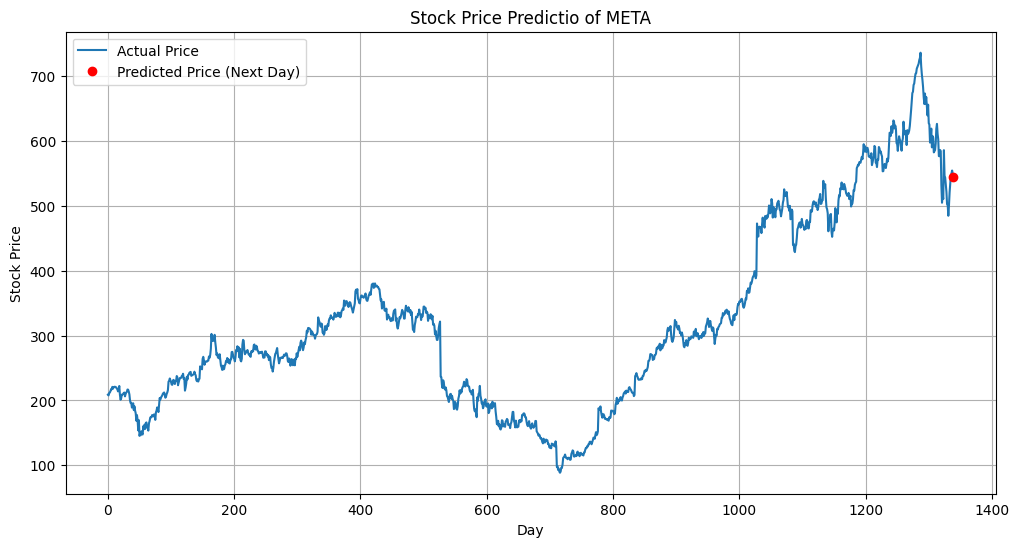

In [267]:
predicted_scaled = model.predict(X_input)
predicted_price = scaler.inverse_transform(predicted_scaled)

print(f"Predicted next closing price:", predicted_price[0][0])

actual_prices = scaler.inverse_transform(scaled_data)

days = [i for i in range(len(actual_prices))]
days_pred = [len(actual_prices)]

plt.figure(figsize = (12, 6))
plt.plot(days, actual_prices, label = 'Actual Price')
plt.plot(days_pred, [predicted_price[0][0]], 'ro', label = 'Predicted Price (Next Day)')
plt.legend()
plt.xlabel("Day")
plt.ylabel("Stock Price")
plt.title("Stock Price Predictio of META")
plt.grid(True)
plt.show()